# Simple bank mutation categorization and visualization tool.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
%matplotlib inline

## Data cleaning


### Creating the table from from the CSV file
-The CSV file came without column names so these needed to be set. <br>

### Data processing

#### decimal convention
-The decimal notation followed dutch convention so the commas needed to replaced with periods and vice versa. <br>

#### data-typing
-The data types of th monetary values were changed from objects to floats <br>
-The date data types were changed from objects to datetime. <br>

In [3]:
raw_mutations = pd.read_csv('mutations_triodos.csv', header=None)

raw_mutations.columns = ['date', 'account', 'value', 'debet_credit', 'sender_reciever', 'offset_account', 
                         'transaction_type', 'description', 'new_balance']

#adds categorical column for later processing
raw_mutations.insert(9, 'category', 'undefined' , True)

# changes dutch decimal notation to international decimal notation
raw_mutations['value'] = [x.replace('.', '') for x in raw_mutations['value']]
raw_mutations['value'] = [x.replace(',', '.') for x in raw_mutations['value']]


raw_mutations['new_balance'] = [x.replace('.', '') for x in raw_mutations['new_balance']]
raw_mutations['new_balance'] = [x.replace(',', '.') for x in raw_mutations['new_balance']]

#sets columns datatypes.
convert_dict = {
    'account' : str,
    'value' : float,
    'debet_credit' : str,
    'sender_reciever' : str,
    'offset_account' : str,
    'transaction_type': str,
    'description' : str,
    'new_balance' : float,
    
}

raw_mutations['date'] = pd.to_datetime(raw_mutations['date'], format='%d-%m-%Y')

cleaned_mutations = raw_mutations.astype(convert_dict)


#cleaned_mutations


,date,account,value,debet_credit,sender_reciever,offset_account,transaction_type,description,new_balance,category
0,2010-07-20,NL03TRIO0212333275,5.00,Credit,Hr J R Mook,8156733,PO,TRANSACTIEDATUM* 19-07-2010,5.00,undefined
1,2011-01-10,NL03TRIO0212333275,711.01,Credit,SOC DIENST DRECHTSTEDEN,28.51.27.764,OV,0000150234 23-08-1989 201101 S HUTING,716.01,undefined
2,2011-01-11,NL03TRIO0212333275,528.41,Credit,Hr J R Mook,8156733,PO,TRANSACTIEDATUM* 11-01-2011,1244.42,undefined
3,2011-01-11,NL03TRIO0212333275,180.00,Credit,Hr J R Mook,8156733,PO,TRANSACTIEDATUM* 11-01-2011,1424.42,undefined
4,2011-01-12,NL03TRIO0212333275,1424.42,Debet,J.R. Mook en/of S. Hutin,21.23.34.832,IT,nan,0.00,undefined
...,...,...,...,...,...,...,...,...,...,...
8513,2023-04-24,NL03TRIO0212333275,7.20,Debet,nan,nan,BA,Jumbo Dordrecht Kris \DORDRECHT \ BETAALAUTOMA...,471.81,undefined
8514,2023-04-24,NL03TRIO0212333275,10.21,Debet,nan,nan,BA,Jumbo Dordrecht Kris \DORDRECHT \ BETAALAUTOMA...,461.60,undefined
8515,2023-04-24,NL03TRIO0212333275,8.00,Debet,nan,nan,BA,CN Bagijn \DORDRECHT \ BETAALAUTOMAAT 23-04-23...,453.60,undefined
8516,2023-04-25,NL03TRIO0212333275,7.20,Debet,nan,nan,BA,Jumbo Dordrecht Kris \DORDRECHT \ BETAALAUTOMA...,446.40,undefined


## Missing data

A lot of sender/reciever data was missing in the CSV file. 
However the missing data could be retrieved from the description column.
The relevant data is selected from the description values with regex and written into the sender/reciever column.

In [4]:
#loops through every row and determines if the sender|reciever data is missing. 
#If that is the case the description value is accesed and the data before the first "/" is written as value
#for the sender/reciever data.
for x in cleaned_mutations.index:
    if cleaned_mutations['sender_reciever'][x] == 'nan':
        description = cleaned_mutations.loc[x, 'description']
        temp = re.split("\\\\", description)
        cleaned_mutations.loc[x, 'sender_reciever'] = temp[0]
    mutations = cleaned_mutations
#mutations

## Data categorization 

The data is processed through a for loop which checks the sender_reciever data for key-words stored in regex groups 
stored in variables. If a match is found in a catagory variable regex group, that data is set to the corresponding catagory.

In [5]:
for x in mutations.index:
    groceries = """albert heijn|jumbo|dirk vdbroek|xenos|kruidvat|picnic|oriental|plus\s|aldi\s|lidl\s|trekpleister|etos|
    linebreak01|ah\s[a-z]|nettorama|emte|supermarkt|^spar|makro"""
    
    rent = "woonbron|overstandsprovisie"
    savings = "hr\sj\sr\smook$|j\.r\.\smook$|internet\ssparen"
    kids = """balleba|s[\.\s]*huting|intertoys|nedgame|ps3games|wheelz4kids|bax\-shop|mojang|blijdorp|keukenhof|
    |newline01|reddingsbrigade|vivistyle|monkey\stown"""
    income = "j.m.w.|tempo\-team|horecavoordeel|werkschoenen|soc\sdienst|^uwv|randstad|sodexo"
    incidental_income = "erven\sc|pfds"
    tikkie = """michel|tikkie|abn\samro|aab\sinz\sretail\sideal\sbet|ing\sbetaalverzoek|rabo\sbetaalverzoek|babita|
    linebreak01|ricardo\smook|merijn\smook|bm\sbevers|annemarie\smook|martin\smook|de\sheer\sm\smook|hr\sm\sm\smook|
    linebreak02|mw\sa\se\smook"""
    utilities = "evides|t.*mobile|eneco|inzamelkalender|^kpn|^nuon|budgetenergie"
    insurance = "promovendum|nowgo|chubb|caresco|ohra\s|^vgz|^zelf\s|^asr|amersfoortse"
    snacks_drinks = """kiosk|delifrance|ah to go|hmshost|laa automaat|lebkov|starbucks|smulhoek|croissant|venezia|
    linebreak01|belicio|haphoek|asz\s|by\smuco|albert\sschweitzer|snack\scorner|sweetwafel|brokking|tdc\srdam|
    linebreak02|smullers|\sako\s|^1[0-9]{5}"""
    mobility = """ns[\s\-][a-z]|total[\s]{0,1}|shell\s|ccv\*ov|nsr terug|qbuzz|schipper|pg\s[a-z]|esso\s|tls[\s/]|
    linebreak01|haan\sg|parking|bp\s|mobiliteitsgelden|anwb|tmc\*p|serrvicepoint\scs|de\skroon|vissers\s[a-z]|
    linebreak02|leaseplan|scheiwijk\shb|dordrecht\sgezo|wegschap\stunnel|sandelingen|eendrachtsplein|q\spark|parkeer|
    linebreak03|^sbgp|betaald\spark|^q8\s|avia\s|texaco|fijneman|jet[\s]{0,1}car|garage"""
    party_supplies = """welkom|cn bagijn|cigo\s|tabakshop|gall\s|party\scenter\sjoy|babylon|apollyon|microdose|
    newline01|jk\srotterdam"""
    lotery = "loterij|poker[\s]{0,1}stars|pstars|counting\shouse\sservices"
    subscriptions = "netflix|spotify"
    belasting = "belasting|svhw|gem[a-z\.\s]*dordrecht|dordrecht/gbd|stadswinkel|gem\sdordt"
    study = "faculteit|duo|dienst\suitvoering|onderwijs|^loi|studystore|erasmus|copyshop\seur|vos\s&\svan|yogananda"
    creditcard = "int\scard|ics"
    food = """domino|hs food|bakker bart|restaurant|paresto|ladage|bro*d|mcd[\sa-z]{0,1}|cateren|thuisbezorgd|zeevis|
    newline01|food\s|^rotterdam\scs|burger\sking|uber|kfc\s|^ash\s|eethuis\skrispijn|takeawaycom|spec\srest\stai|
    newline02|toko\sdingo|backwerk|albron|vitam\scatering|cafetaria"""
    fines = "cjib"
    healthcare = "famed|infomedics|apotheek|tandarts"
    loansharks = "credios|trust\skrediet"
    shopping = """bol[\.]{0,1}com|hema|zuidplein|bruna|karwei|blokker|action|ikea|mm\sd|dekkers\sboek|selecta|
    newline01|iz\s\*sticht|bigbazar|vvv\scards|hakky|used\sproducts|intratuin|primera|nwe\shoop|cnl\svia|de\sboekenla|
    newline02|steampowered|global\scollect|opnieuw\s&\sco|blije\sboeddha|zwarte[\s]{0,1}valk|cees\svan\sde\shorst|happy\sspirit"""
    legal = "hoogerw|dienst\sjustis"
    pin = "geldautomaat|geldmaat|eurozone|envoy"
    leisure = """cafe[\s\-]|stichting\sculture|westkop|baker\s&|de\smerwelanden|wantijpaviljoen|dutchband|bod\sevents|
    newline01|holy\smoly|ozkan|old\sdutch|^mezz\s|indrapoera|shots|pathe|markthal|the\schamp|dependance|elysium|
    newline02|bowling|bibelot|thermen|schouwburg"""
    banking = 'kosten\striodos|kosten\svervangende\spas|jaarlijkse\spasbijdrage'
    clothing = "primark|h&m|^c&a|zeeman|^v&d|perry\ssport|nelson"
    vacation = """la\sfoir|pommerloch|wokaway\sleuven|camping|point\schaud|decathlon|paylogic\svia\sing|weezevent|
    linebreak01|aral\sluxembourg|neckermann"""
    home_supplies = "karei|sanifair|tuk\-inn|casatrend|electro|kwantum|karwei|leen\sbakker|coolblue"
    shared_account_santi = "en/of|westra"
    
    sender_reciever = mutations.loc[x, 'sender_reciever'].lower()
    
    if bool(re.search((groceries), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'groceries'
    elif bool(re.search((rent), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'rent'
    elif bool(re.search((savings), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'savings_account'
    elif bool(re.search((kids), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'kids'
    elif bool(re.search((income), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'income'
    elif bool(re.search((tikkie), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'tikkie'
    elif bool(re.search((utilities), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'utilities'    
    elif bool(re.search((insurance), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'insurance'        
    elif bool(re.search((snacks_drinks), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'snacks_drinks'       
    elif bool(re.search((mobility), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'mobility'   
    elif bool(re.search((party_supplies), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'party supplies'   
    elif bool(re.search((lotery), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'lotery'   
    elif bool(re.search((subscriptions), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'subscriptions'                
    elif bool(re.search((belasting), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'taxes'    
    elif bool(re.search((study), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'study'        
    elif bool(re.search((creditcard), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'creditcard'        
    elif bool(re.search((food), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'food'    
    elif bool(re.search((fines), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'fines'        
    elif bool(re.search((healthcare), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'healthcare'    
    elif bool(re.search((loansharks), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'loansharks'        
    elif bool(re.search((shopping), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'shopping'
    elif bool(re.search((legal), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'legal'
    elif bool(re.search((pin), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'pin'
    elif bool(re.search((leisure), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'leisure'
    elif bool(re.search((banking), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'banking'
    elif bool(re.search((clothing), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'clothing'
    elif bool(re.search((vacation), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'vacation'
    elif bool(re.search((home_supplies), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'home_supplies'
    elif bool(re.search((shared_account_santi), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'shared_account_santi'
    elif bool(re.search((incidental_income), sender_reciever)) == True:
        mutations.loc[x, 'category'] = 'incidental_income'

## Data visualization

The below declared function resamples and visualizes the data with the given frequency from the given period until present for the given catagory. <br><br>
### The function variables are: 
-df: Defines the data frame.<br>
-cat: Defines the catagory. <br> 
-freq: Defines the frequency for resampling. (Y=year, m=month, w=week)<br>
-period: Defines the start date of the required period. (YY-MM-DD)<br>

In [7]:
def plt_by_cat(df=mutations, cat='income', freq='Y', period='2010-01-01'):
    date_indexed_mutations = mutations.set_index('date')
    
    cat_debet = date_indexed_mutations[(date_indexed_mutations['category'] == cat) & 
                                       (date_indexed_mutations['debet_credit'] == 'Debet') & 
                                       (date_indexed_mutations.index > period)]
    cat_credit = date_indexed_mutations[(date_indexed_mutations['category'] == cat) & 
                                        (date_indexed_mutations['debet_credit'] == 'Credit') &
                                        (date_indexed_mutations.index > period)]
    
    resampled_cat_debet = cat_debet.resample(freq).sum()
    resampled_cat_debet.drop('new_balance', axis=1, inplace=True)
    resampled_cat_debet['period'] = resampled_cat_debet.index.strftime('%Y-%'+freq)
    
    resampled_cat_credit = cat_credit.resample(freq).sum()
    resampled_cat_credit.drop('new_balance', axis=1, inplace=True)
    resampled_cat_credit['period'] = resampled_cat_credit.index.strftime('%Y-%'+freq)
    
    if (len(resampled_cat_credit) > 0) and (len(resampled_cat_debet) > 0):
        resampled_cat_nett = resampled_cat_debet.merge(resampled_cat_credit, how='outer', left_on='period', right_on='period').fillna(0)
        resampled_cat_nett.sort_values('period', inplace=True)
        resampled_cat_nett['value'] = resampled_cat_nett['value_y'] - resampled_cat_nett['value_x']
    elif (len(resampled_cat_credit) > 0) and (len(resampled_cat_debet) == 0):
        resampled_cat_nett = resampled_cat_credit
    else:
        resampled_cat_nett = resampled_cat_debet
        
    
    
    x=resampled_cat_debet['period']
    y=resampled_cat_debet['value']
    
    print(cat + '_debet')
    plt.figure(figsize=(20,12))
    plt.bar(x, y)
    plt.xticks(rotation= 90)
    plt.show()
    
    x=resampled_cat_credit['period']
    y=resampled_cat_credit['value']
    
    print(cat + '_credit')
    plt.figure(figsize=(20,12))
    plt.bar(x, y)
    plt.xticks(rotation= 90)
    plt.show()
    
    x=resampled_cat_nett['period']
    y=resampled_cat_nett['value']
    
    print(cat + '_nett')
    plt.figure(figsize=(20,12))
    plt.bar(x, y)
    plt.xticks(rotation= 90)
    plt.show()
    


party supplies_debet


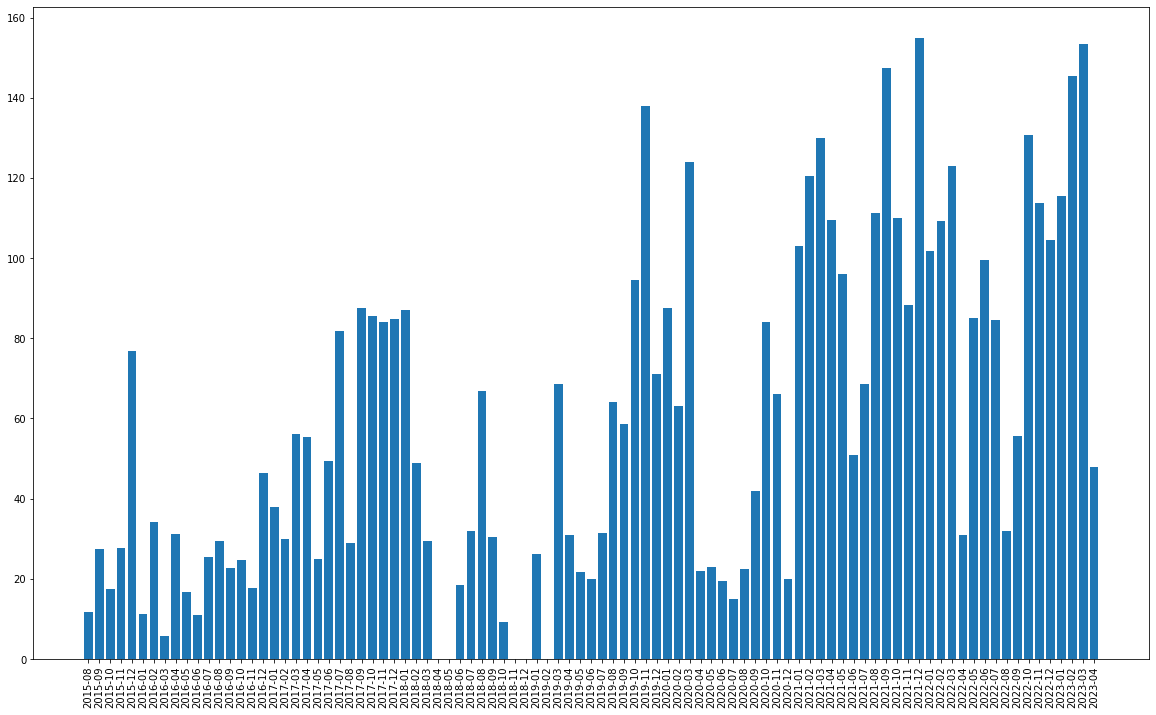

party supplies_credit


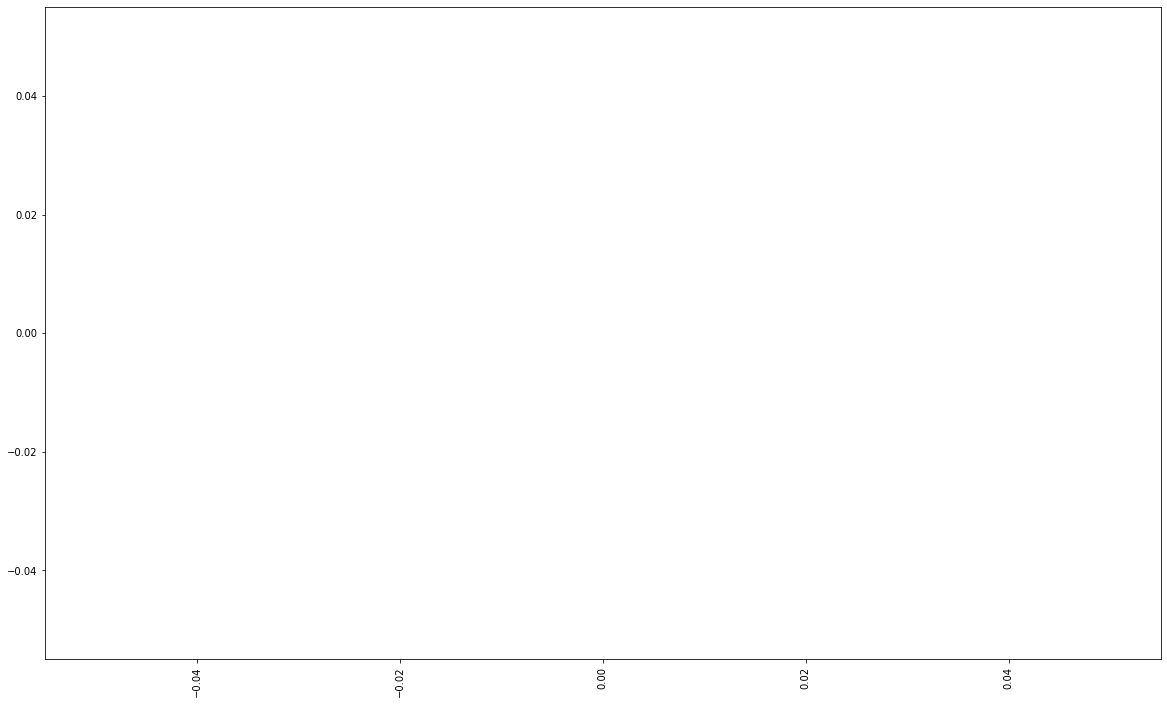

party supplies_nett


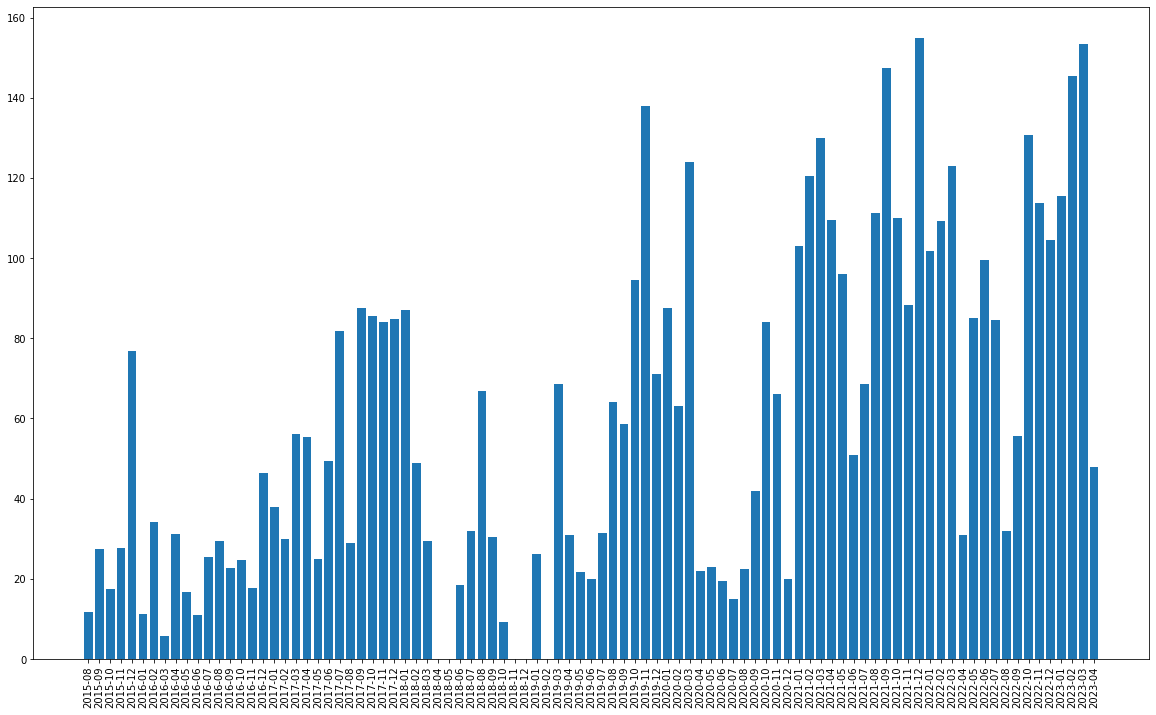

In [27]:
plt_by_cat(cat='party supplies', freq='m', period='2015-01-01')